In [25]:
from os.path import join as pjoin
import numpy as np
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi
from dipy.data.fetcher import fetch_syn_data
from dipy.io.image import load_nifti, save_nifti
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
import nibabel as nib



In [2]:

atlas_dir = "C:\\Users\\Louis Lovat\\Desktop\\Memoire\\Atlas_Maps"
static_image_file = "FSL_HCP1065_FA_1mm.nii.gz"
moving_data, moving_affine, moving_image = load_nifti(pjoin(atlas_dir, static_image_file), return_img=True)
moving = moving_data
moving_grid2world = moving_affine

study_dir = "C:\\Users\\Louis Lovat\\Desktop\\Memoire\\study"
patient_dir = "20_01_01_E0"
moving_image_file = "C:\\Users\\Louis Lovat\\Desktop\\Memoire\\study\\20_01_01_E0\\microstructure\\dti\\20_01_01_E0_FA.nii.gz"
static_data, static_affine, static_image = load_nifti(moving_image_file, return_img=True)
static = static_data
static_grid2world = static_affine


end


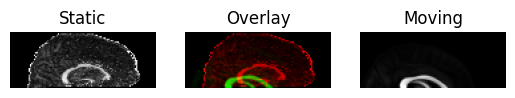

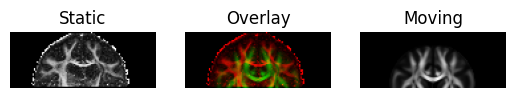

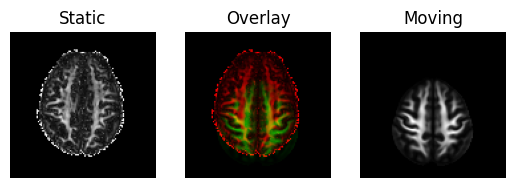

In [3]:

identity = np.eye(4)
affine_map = AffineMap(identity,
                       static.shape, static_grid2world,
                       moving.shape, moving_grid2world)
resampled = affine_map.transform(moving)

regtools.overlay_slices(static, resampled, None, 0,
                        "Static", "Moving", "resampled_0.png")
regtools.overlay_slices(static, resampled, None, 1,
                        "Static", "Moving", "resampled_1.png")
regtools.overlay_slices(static, resampled, None, 2,
                        "Static", "Moving", "resampled_2.png")
print("end")

end


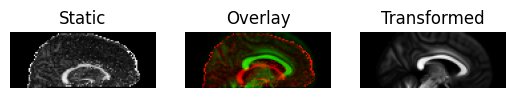

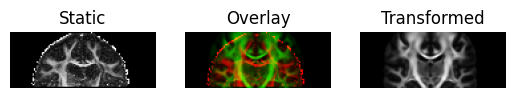

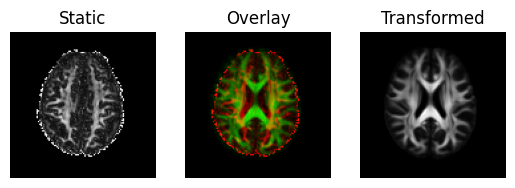

In [4]:
c_of_mass = transform_centers_of_mass(static, static_grid2world,
                                      moving, moving_grid2world)
transformed = c_of_mass.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_com_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_com_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_com_2.png")
print("end")

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
end


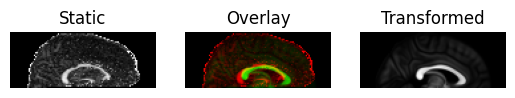

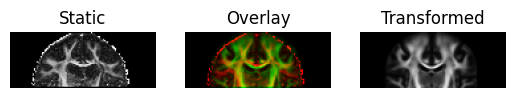

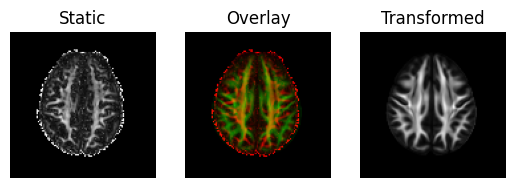

In [5]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)
level_iters = [10000, 1000, 100]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]

affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

transform = TranslationTransform3D()
params0 = None
starting_affine = c_of_mass.affine
translation = affreg.optimize(static, moving, transform, params0,
                              static_grid2world, moving_grid2world,
                              starting_affine=starting_affine)

transformed = translation.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_trans_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_trans_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_trans_2.png")
print("end")

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
end


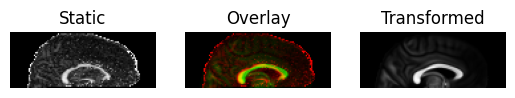

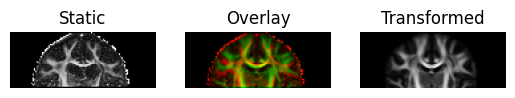

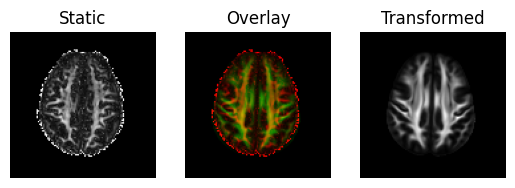

In [6]:
transform = RigidTransform3D()
params0 = None
starting_affine = translation.affine
rigid = affreg.optimize(static, moving, transform, params0,
                        static_grid2world, moving_grid2world,
                        starting_affine=starting_affine)
                        
transformed = rigid.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_rigid_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_rigid_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_rigid_2.png")
print("end")

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
end


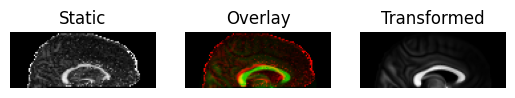

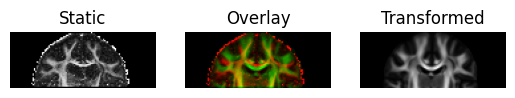

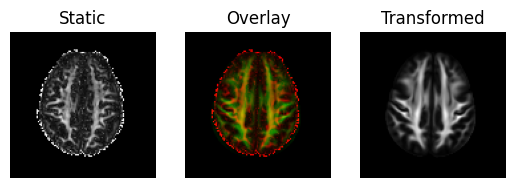

In [7]:
transform = AffineTransform3D()
params0 = None
starting_affine = rigid.affine
affine = affreg.optimize(static, moving, transform, params0,
                         static_grid2world, moving_grid2world,
                         starting_affine=starting_affine)

transformed = affine.transform(moving)
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_affine_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_affine_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_affine_2.png")
print("end")

end


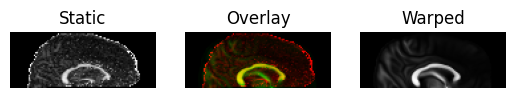

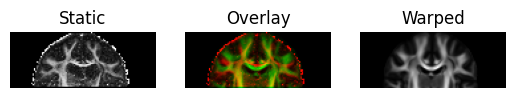

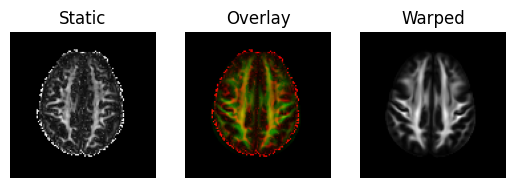

In [8]:
starting_affine = affine.affine
free_deform_metric = CCMetric(3)
free_deform_level_iters = [10, 10, 5]
sdr = SymmetricDiffeomorphicRegistration(free_deform_metric, free_deform_level_iters)
mapping = sdr.optimize(static, moving, static_affine, moving_affine, prealign=starting_affine)
warped_moving = mapping.transform(moving)

regtools.overlay_slices(static, warped_moving, None, 0,
                        "Static", "Warped", "warped_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Warped", "warped_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Warped", "warped_2.png")
print("end")

In [47]:
new_img = nib.Nifti1Image(warped_moving, np.eye(4), header=static_image.header)
header = new_img.header
header['pixdim'][1:4] = [2, 2, 2,] # for example
# Update the header information in the NIfTI file
new_img.update_header()
nib.save(new_img, "test_wraped.nii.gz")
test = nib.load("test_wraped.nii.gz")
print(test.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 110 110  42   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 2. 2. 2. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1. 0. 0. 0.]
srow_y          : [0. 1

In [53]:
dat1, af1, im1 = load_nifti("C:\\Users\\Louis Lovat\\Desktop\\Memoire\\study\\20_01_01_E1\\microstructure\\dti\\20_01_01_E1_FA.nii.gz", return_img=True)
dat2, af2, im2 = load_nifti("C:\\Users\\Louis Lovat\\Desktop\\Memoire\\study\\20_01_01_E1\\transformed\\20_01_01_E1_FSL_HCP1065_FA_1mm.nii.gz", return_img=True)
print(im1.header)
print(im2.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 110 110  68   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.5
quatern_c       : -0.5
quatern_d       : -0.5
qoffset_x       : -65.125
qoffset_y       : 109.625
qoffset_z       : -129.625
srow_x          : [  0.      0. 